### Parameters = [tage, log tau, metallicity, dust]

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import kuaizi

In [4]:
kuaizi.set_matplotlib(style='nature', usetex=False)
kuaizi.set_env(project='popsed', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/popsed/'

In [5]:
import fsps
import sedpy
from sedpy.observate import load_filters
import prospect
from prospect.sources.constants import cosmo #WMAP9
import exspect
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')

In [6]:
from popsed import mock
from popsed.sfh import params_to_sfh, parametric_sfr, parametric_mwa

In [7]:
# SDSS filters
sdss = ['sdss_{0}0'.format(b) for b in 'ugriz']

### Let's think about the prior distributions for sampling traning SEDs

In order to cover SDSS five bands, we need spectrum covering **2000** A to 11000 A.

Let's sample the prior, instead of doing a grid search.


$\log\, M_\star\ [M_\odot] \sim \rm Uniform[9.0, 12.0, 0.1]$ (fast, **don't need to include in the emulator**)

$t_{\rm age}\ [\rm Gyr] \sim \rm Uniform[0.5, t_{univ}(z), 0.4]$ (fast)

$\log\, \tau\ [\rm Gyr] \sim \rm Uniform[-2, 2, 0.2]$ (slow)

$\log Z \sim \rm Uniform[-2, 0.5]$

$z=0.0$. However, there should be a constraint on redshift and tage in `speculator`.

$\hat{\tau}_2 \sim \mathcal{N}(0.3, 1^2)$ with truncations at [0, 4], this is the `dust2` parameter. See Conroy09a.

In [10]:
import itertools

In [11]:
dlambda_spec = 2
wave_lo = 1500
wave_hi = 12000
wavelengths = np.arange(wave_lo, wave_hi, dlambda_spec)

In [12]:
N_samples = 5000
zred_set = np.random.uniform(0.0, 0.0, N_samples)
mass_set = np.random.uniform(1.0, 1.0, N_samples) # Fix mass to 1 M_\odot #10**(np.linspace(9, 12, 20))
tage_set = np.random.uniform(1, float(cosmo.age(zred_set[0]).value), size=N_samples)
tau_set = 10**(np.random.uniform(-2, 2, size=N_samples))
log_Z_set = np.random.uniform(-2, 0.5, size=N_samples)
dust2_set = np.random.uniform(0, 4, size=N_samples)

print('Total number of samples in parameter space:')
print(len(tau_set))
#print(len(tau_set) * len(tage_set) * len(mass_set) * len(zred_set) * len(log_Z_set))

Total number of samples in parameter space:
5000


In [13]:
params_set = np.vstack([zred_set, mass_set, tage_set, tau_set, log_Z_set, dust2_set]).T

#### Looks not bad? Try to generate some SEDs and benchmark the speed

In [14]:
sps = mock.build_sps(add_realism=False)

In [15]:
import time

In [16]:
start = time.time()
# This will take forever
obs_set = []
# we start with a simple model: tau-SFH, no dust attenuation and emission, no nebular emission
for i in range(N_samples):
    zred, mass, tage, tau, logzsol, dust2 = params_set[i]
    model = mock.build_model(mass=mass, zred=zred, logzsol=logzsol,
                             sfh=1, tage=tage, tau=tau, 
                             add_dustabs=True, dust2=dust2,
                             uniform_priors=True)
    obs = mock.build_obs(sps, model, add_noise=False, 
                         dlambda_spec=dlambda_spec, wave_lo=wave_lo, wave_hi=wave_hi,
                         # we use true_spectrum and true_mock for emulation
                         # Noise can be added afterward, with a better noise model
                         snr_spec=10, snr_phot=20,
                         filterset=sdss, 
                         continuum_optimize=False)
    obs_set.append(obs)

with open(f'./train_sed/train_sed_dust_Z_{N_samples}.pkl', 'wb') as f:
    pickle.dump(obs_set, f)
    f.close()
    
end = time.time()
print('Elapsed time = ', end - start)

Elapsed time =  608.2706341743469


In [17]:
len(obs_set)

5000

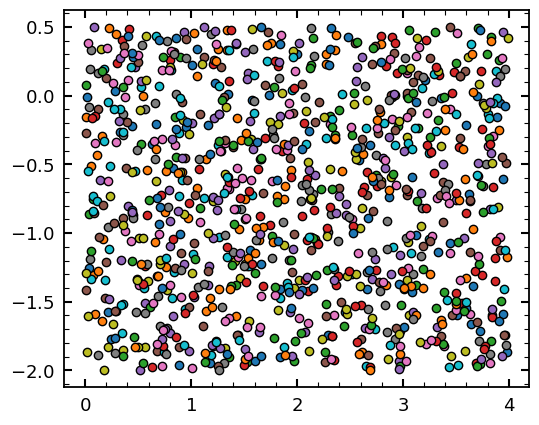

In [18]:
for obs in obs_set[1000:2000]:
    plt.scatter(obs['mock_params']['dust2'][0], obs['mock_params']['logzsol'][0])

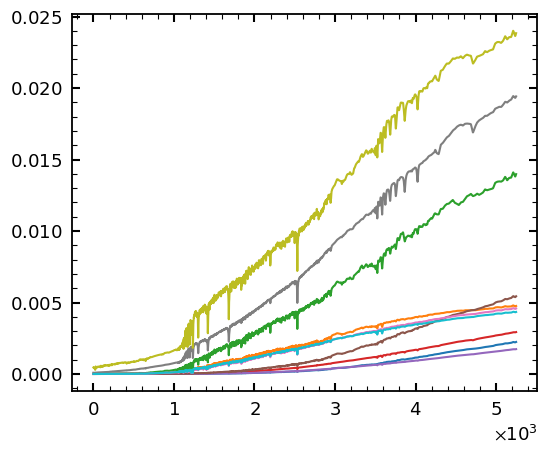

In [19]:
for obs in obs_set[1000:1010]:
    plt.plot(obs['true_spectrum'])

In [ ]:
NOW WE HAVE TWO SAMPLES, EACH WITH 5000 SEDS. TO DO TOMORROW;.

## Load obs_set, and translate it into numpy arrays

In [19]:
with open('./train_sed/train_sed_1600.pkl', 'rb') as f:
    obs_set = pickle.load(f)
    f.close()

No handles with labels found to put in legend.


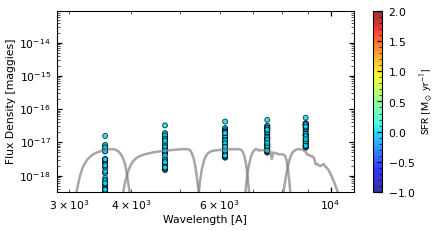

In [20]:
obs = obs_set[0]

# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
plt.figure(figsize=(8, 4))

# plot all the data
for ob in np.array(obs_set)[np.random.randint(0, len(obs_set), 40)]:
    sfr = parametric_sfr(times=np.array([0]), **ob['mock_params'], tavg=0.05)
#     sct = plt.scatter(wphot, ob['maggies'],
#          #label='All observed photometry',
#          marker='o', alpha=0.8, vmin=1, vmax=10,
#          c=np.ones_like(wphot) * ob['mock_params']['tau'], cmap='jet')
    sct = plt.scatter(wphot, ob['maggies'],
         #label='All observed photometry',
         marker='o', alpha=0.8, vmin=-1, vmax=2,
         c=np.ones_like(wphot) * sfr, cmap='jet')
    
plt.colorbar(sct, label=r'$\rm SFR\ [M_\odot\ yr^{-1}]$')
    
# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)
    
# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin / 10, ymax * 1000])
#plt.xscale("log")
plt.yscale("log")
plt.legend(loc='best')

Text(0.5, 0.98, 'Randomly selected 80 SEDs in the traning sample')

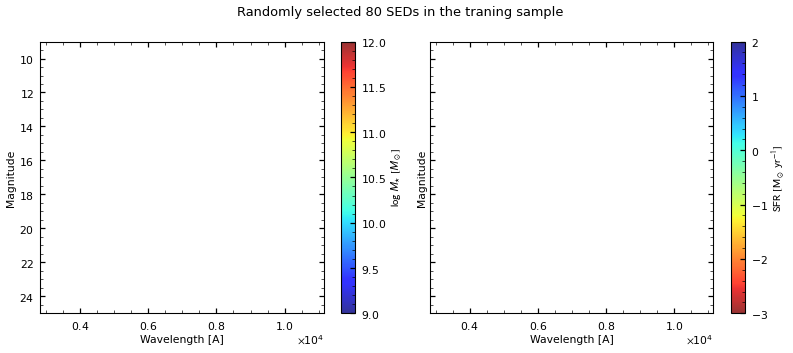

In [21]:
obs = obs_set[0]
wphot = obs["phot_wave"]
# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax =  -2.5 * np.log10(obs["maggies"].min())*0.8, -2.5 * np.log10(obs["maggies"].max())/0.4


fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

plt.sca(axes[0])

# plot all the data
for ob in np.array(obs_set)[np.random.randint(0, len(obs_set), 80)]:
    sfr = parametric_sfr(times=np.array([0]), **ob['mock_params'], tavg=0.05)
    sct = plt.scatter(wphot, -2.5 * np.log10(ob['maggies']),
         marker='o', alpha=0.8, vmin=9, vmax=12,
         c=np.ones_like(wphot) * np.log10(ob['mock_params']['mass']), cmap='jet')
plt.colorbar(sct, label=r'$\log\, M_{\star}\ [M_\odot]$')
# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Magnitude')
plt.xlim([xmin, xmax])
plt.ylim([25, 9])

plt.sca(axes[1])
# plot all the data
for ob in np.array(obs_set)[np.random.randint(0, len(obs_set), 80)]:
    sfr = parametric_sfr(times=np.array([0]), **ob['mock_params'], tavg=0.05)
    sct = plt.scatter(wphot, -2.5 * np.log10(ob['maggies']),
         #label='All observed photometry',
         marker='o', alpha=0.8, vmin=-3, vmax=2,
         c=np.ones_like(wphot) * np.log10(sfr), cmap='jet_r')
plt.colorbar(sct, label=r'$\rm SFR\ [M_\odot\ yr^{-1}]$')
# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Magnitude')
plt.xlim([xmin, xmax])
plt.ylim([25, 9])


plt.suptitle('Randomly selected 80 SEDs in the traning sample')

In [22]:
# t, sfr, cmf = params_to_sfh(model.params, 
#                             time=np.linspace(0, cosmo.age(model.params['zred']).value, 30), 
#                             agebins=None)

## Translate the `obs_set` into numpy arrays of parameters, SEDs, and spectra

Spectrum: `dlambda_spec=2.0, wave_lo=3800, wave_hi=7000.0`. Length = 1600

`wavelength = np.arange(3800, 7000, 2)`.

Files are stored at `/scratch/gpfs/jiaxuanl/Data/popsed/train_sed`

In [23]:
obs = obs_set[10]
len_spec = len(obs['wavelength'])
len_phot = len(obs['phot_wave'])

In [25]:
%%time
# Array storing all spectra
spec_arr = np.zeros((len(obs_set), len_spec))
for i, obs in enumerate(obs_set):
    spec_arr[i] = np.log10(obs['true_spectrum'])
    
# Need to take log of the spectrum flux density

CPU times: user 366 ms, sys: 869 ms, total: 1.24 s
Wall time: 1.28 s


In [26]:
%%time
# Array storing all SEDs
phot_arr = np.zeros((len(obs_set), len_phot))
for i, obs in enumerate(obs_set):
    phot_arr[i] = obs['true_maggies']

CPU times: user 1.9 ms, sys: 991 µs, total: 2.89 ms
Wall time: 2.89 ms


In [27]:
list(obs['mock_params'].keys())

['zred',
 'mass',
 'logzsol',
 'dust2',
 'sfh',
 'tage',
 'imf_type',
 'dust_type',
 'tau']

In [28]:
keys = ['zred', 'mass', 'logzsol', 'dust2', 'sfh', 
        'tage', 'imf_type', 'dust_type', 'tau'] # , 'sfr'

In [29]:
%%time
param_arr = np.array([[float(obs['mock_params'][key]) for key in keys] for obs in obs_set])

param_arr[:, -1] = np.log10(param_arr[:, -1]) # tau to log(tau)

CPU times: user 9.43 ms, sys: 127 µs, total: 9.56 ms
Wall time: 9.74 ms


In [30]:
from sklearn.model_selection import train_test_split

In [31]:
with open('./train_sed/log_spec_all.npy', 'wb') as f:
    np.save(f, spec_arr)

with open('./train_sed/phot_all.npy', 'wb') as f:
    np.save(f, phot_arr)
    
with open('./train_sed/param_all.npy', 'wb') as f:
    np.save(f, param_arr)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(spec_arr, param_arr, test_size=0.20, random_state=42)

In [33]:
with open('./train_sed/log_spec_train.npy', 'wb') as f:
    np.save(f, X_train)
    
with open('./train_sed/log_spec_vali.npy', 'wb') as f:
    np.save(f, X_test)
    
with open('./train_sed/param_train.npy', 'wb') as f:
    np.save(f, y_train)
    
with open('./train_sed/param_vali.npy', 'wb') as f:
    np.save(f, y_test)

In [34]:
# with open('./train_sed/phot_1600.npy', 'wb') as f:
#     np.save(f, phot_arr)
    
# with open('./train_sed/log_spec_1600.npy', 'wb') as f:
#     np.save(f, spec_arr)
    
# with open('./train_sed/param_1600.npy', 'wb') as f:
#     np.save(f, param_arr)

**Galaxies with SFR=0 and very small $\tau$ ($\tau$ < 0.02) just have zero fluxes. Need to remove them??**

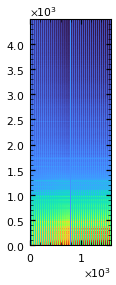

In [35]:
from astropy.visualization import simple_norm
test = spec_arr / np.mean(spec_arr, axis=1)[:, np.newaxis]
#norm = simple_norm(spec_arr / np.mean(spec_arr, axis=1)[:, np.newaxis], 'sqrt')
plt.imshow(test.T)#, norm=norm)

### Some tests

In [7]:
dlambda_spec = 2
wave_lo = 1500
wave_hi = 12000
wavelengths = np.arange(wave_lo, wave_hi, dlambda_spec)

In [434]:
import torch
from torchinterp1d import Interp1d

In [435]:
## Load the NN emulator `speculator`
with open('./speculator_best_recon_model.pkl', 'rb') as f:
    speculator = pickle.load(f)

In [154]:
redshift = 0.1

In [146]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])
params = np.load('./train_sed/param_all.npy')[:, ~flag]
log_spec_all = np.load('./train_sed/log_spec_all.npy')

In [147]:
params[0]

array([ 1., -2.])

In [155]:
param = torch.Tensor([[5, 0, np.log10(1), redshift]]).to('cuda')
spec1 = speculator._predict_spec_with_mass_redshift(param)

tensor([[1.9681e+15]], device='cuda:0')


In [156]:
model = mock.build_model(mass=1, zred=redshift, logzsol=-0.5,
                         tage=5, tau=10**0, 
                         sfh=1, add_dustabs=False,
                         #dust2=0.2,
                         uniform_priors=True)
obs = mock.build_obs(sps, model, add_noise=False, 
                     dlambda_spec=dlambda_spec, wave_lo=wave_lo, wave_hi=wave_hi,
                     # we use true_spectrum and true_mock for emulation
                     # Noise can be added afterward, with a better noise model
                     snr_spec=10, snr_phot=20,
                     filterset=sdss, 
                     continuum_optimize=False)

In [150]:
wave_rest = wavelengths
wave_stretch = wave_rest / (1 + redshift)
wave_stretch

array([ 1363.63636364,  1365.45454545,  1367.27272727, ...,
       10903.63636364, 10905.45454545, 10907.27272727])

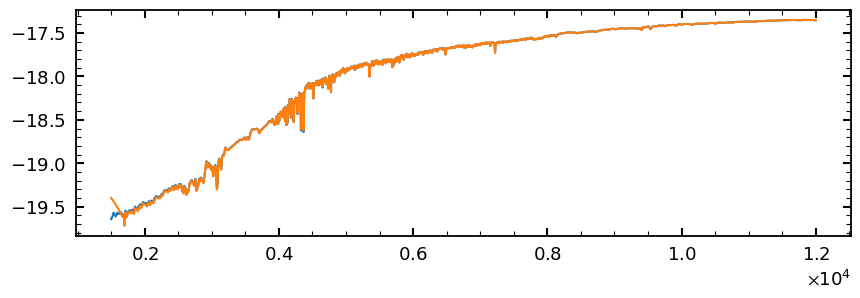

In [157]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=100)
#plt.plot(wave_rest, np.log10(obs0['true_spectrum'] / dfactor))
plt.plot(wave_rest, np.log10(obs['true_spectrum']))
plt.plot(wave_rest, np.log10(spec1[0].detach().cpu().numpy()))
#plt.plot(wave_rest, np.log10(10**log_spec_all[0] / dfactor))